In [1]:
'''This salary prediction model pulls job data and predicts salaries across multiple models. 
    It then saves the model and produces a prediction file.'''

'This salary prediction model pulls job data and predicts salaries across multiple models. \n    It then saves the model and produces a prediction file.'

In [2]:
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

### Import packages

In [206]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import time
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

### Defining Data class

In [207]:
class Data:
    def __init__(self):
        '''create train and test dataframes'''
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.train_eda = pd.DataFrame()
        self.train_raw = pd.DataFrame()
        self.test_raw = pd.DataFrame()
        self.train_df = self._create_train_df(train_file)
        self.test_df = self._create_test_df()

    def _create_train_df(self, train_df):
        '''create train dataframe'''
        target = self.load_file(target_file)
        df_train = self.load_file(train_df)
        df_train = self._join_df(df_train, target)
        df_train = self._correct_data(df_train)
        self.train_eda = df_train
        df_train = self._clean_data(df_train)
        df_train = self.shuffle_data(df_train)
        self.train_raw = df_train
        df_train = self.label_encode(df_train)
        return df_train

    def _create_test_df(self):
        '''create test dataframe'''
        df_test = self.load_file(test_file)
        df_test = self._correct_data(df_test)
        self.test_raw = df_test
        df_test = self.label_encode(df_test)
        return df_test

    def shuffle_data(self, dataframe):
        '''shuffling data'''
        return shuffle(dataframe, random_state=42).reset_index(drop=True)

    def _clean_data(self, dataframe):
        '''remove outliers from data'''
        return dataframe[(dataframe.salary > 8) & (dataframe.salary < 220)]

    def _correct_data(self, dataframe):
        '''correcting data values'''
        list_index = dataframe[(dataframe['degree'] != 'HIGH_SCHOOL')
                               & (dataframe['degree'] != 'NONE')
                               & (dataframe['major'] == 'NONE')
                              ].index
        dataframe.loc[list_index, 'major'] = 'MISSING'
        return dataframe

    def label_encode(self, dataframe):
        '''label encode dataframes'''
        labelencode = LabelEncoder()
        for val in col_cat:
            dataframe[val] = labelencode.fit_transform(dataframe[val])
        return dataframe

    def _join_df(self, train_df, target):
        '''join train and target dataframes'''
        return pd.merge(train_df, target, on=col_id, how='inner')

    def load_file(self, file):
        '''load files'''
        return pd.read_csv(file)

### Defining Feature Engineering class

In [208]:
class FeatureEngineering:
    def __init__(self, train_raw, train_df, test_raw, test_df):
        '''create train and test dataframes'''
        self.train_df = train_df
        self.train_raw = train_raw
        self.test_df = test_df
        self.test_raw = test_raw
        self._groupby(self.train_raw, train_df, self.test_raw)

    def _groupby(self, train_raw, train_df, test_raw):
        '''parse through each categorical column and compute mean of each unique value'''
        for i in range(0, len(col_cat)):
            df_temp = self._compute_mean(train_raw, i)
            list_col_temp = df_temp[col_cat[i]]
            list_col_target = df_temp[col_target]
            dict_temp = self._create_dictionary(df_temp, list_col_temp, list_col_target)
            data.train_df[col_cat[i] + '_mean'] = self._map_dict(train_raw, i, dict_temp)
            data.test_df[col_cat[i] + '_mean'] = self._map_dict(test_raw, i, dict_temp)
            self._append_columns(train_df, i)
        data.col_all = col_cat + col_num

    def _compute_mean(self, train_raw, i):
        '''compute mean of unique categorical values'''
        df_raw = train_raw.groupby(col_cat[i])[col_target].mean()
        return df_raw.sort_values(ascending=True).reset_index()

    def _create_dictionary(self, df_temp, list_col_temp, list_col_target):
        '''create dictionary of unique categorical values and mean salary values'''
        dict_temp = {}
        for j in range(0, len(df_temp)):
            dict_temp.update([(list_col_temp[j], list_col_target[j])])
        return dict_temp

    def _map_dict(self, df_eda, i, dict_temp):
        '''mapping dictionary values'''
        return df_eda[col_cat[i]].map(dict_temp)

    def _append_columns(self, train_df, i):
        '''appending new column names to col_num list'''
        data.col_num.append(train_df[col_cat[i] + '_mean'].name)
        
fe = FeatureEngineering(data.train_raw, data.train_df, data.test_raw, data.test_df)

### Defining Model class

In [209]:
class Model:
    def __init__(self):
        '''create train dataframe'''
        self.train_df = train_features
        self.filename = 'best_model.sav'

    def add_model(self, model):
        '''add new model'''
        start_time = time.time()
        model_container[model] = self._score_model(model, self.train_df, train_target)
        pass_temp = model_container[model]
        self._model_summary(model, pass_temp)
        self._elapsed_time(start_time)

    def _elapsed_time(self, start_time):
        elapsed_time = round((time.time() - start_time) / 60, 2)
        print('training time:', elapsed_time, 'minutes')

    def _model_summary(self, model, pass_temp):
        print(model)
        print('score:', model_container[model], '\n')

    def fit_model(self, model, train_df, target):
        '''fit model'''
        return model.fit(train_df, target)

    def predict_model(self, model_selected, test_df, train_df, target):
        '''predict and store best model'''
        model = self.fit_model(model_selected, train_df, target)
        self._save_model(model, self.filename)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        return prediction_results

    def _important_features(self, model):
        '''create feature importance dataframe'''
        if hasattr(model, 'feature_importances_'):
            col_feat_rank = pd.DataFrame(model.feature_importances_, columns=['score'])
            col_feat = pd.DataFrame(data.col_all, columns=['feature'])
            df_feat = pd.concat([col_feat, col_feat_rank], axis=1)
            df_feat = df_feat.sort_values('score', ascending=False).reset_index(drop=True)
            print('\n', model)
            print("\nFeature Importances\n", df_feat)
            self._feature_barplot(df_feat)
        else:
            print("\nModel does not have feature_importances_ attribute.")

    def _feature_barplot(self, dataframe):
        '''create feature importance barplot'''
        fig = sns.barplot(dataframe.score, dataframe.feature, palette='Blues_d')
        fig.set_title('Feature Importances')

    def best_scoring_model(self):
        '''select best scoring model'''
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._best_model_summary(best_model, best_score)
        return best_model

    def _best_model_summary(self, best_model, best_score):
        '''print summary results of best model'''
        print('The best model is:\n', best_model)
        print('\nThe best score is:\n', best_score)

    def load_model(self, test_df):
        '''load best model and call feature importance'''
        if load_best_model:
            print('\nLoading saved best model...')
            loading_best_model = joblib.load(self.filename)
            self._important_features(loading_best_model)
            loading_best_model.predict(test_df)
        else:
            print('\nNo prediction file was created because load_best_model is set to false.')

    def _save_model(self, model, filename):
        '''save best model'''
        if save_best_model:
            pickle.dump(model, open(filename, 'wb'))
            print('The model has been saved.')
        else:
            print('\nBest performing model not saved because save_best_model is set to false.')

    def _score_model(self, model, train_df, target_train):
        '''score model'''
        score = np.mean(cross_val_score(
                                        model, train_df, target_train,
                                        scoring='neg_mean_squared_error',
                                        cv=set_cv, n_jobs=num_proc
                                        )
                        )
        return -1.0 * score

    def _save_prediction(self, prediction_results):
        '''save predictions as csv file'''
        col_jobid = pd.DataFrame(data.test_df.jobId)
        pred_temp = pd.DataFrame(prediction_results, columns=['salary'])
        pd.concat([col_jobid, pred_temp], axis=1).to_csv(dir_pred)

### Defining parameters to run model

In [210]:
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

set_cv = 2
num_proc = -1
save_best_model = True
load_best_model = True
dir_pred = '/Users/krahman/work/salarypredictionportfolio/predictions/test_salaries.csv'
model_container = {}

### Create data object

In [211]:
data = Data()

### Create feature engineering object

In [212]:
fe = FeatureEngineering(data.train_raw, data.train_df, data.test_raw, data.test_df)

### Finalize training, target and test dataframes for our model

In [214]:
train_features = data.train_df[data.col_all]
train_target = data.train_df[col_target]
test_features = data.test_df[data.col_all]

###
# train_features = data.train_df.loc[:10000,:]
# train_target = data.train_df.loc[:10000,:]
# test_features = data.test_df.loc[:10000,:]
# train_features = train_features[data.col_all]
# train_target = train_target[col_target]
# test_features = test_features[data.col_all]
# ##

### Create model object

In [215]:
model_class = Model()

In [216]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# data.train_df

### Add model, score, select best model, create prediction file and print summary

In [217]:
# rfr final
model_class.add_model(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=39, min_samples_split=114,
                      min_weight_fraction_leaf=0, n_estimators=200, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
               )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=39, min_samples_split=114,
                      min_weight_fraction_leaf=0, n_estimators=200, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
score: 352.5573182298023 

training time: 5.88 minutes


In [218]:
# xgbr final
model_class.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)
               )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)
score: 340.9911792052292 

training time: 3.55 minutes


In [219]:
# gbr final RERUN, store models, then set save model to false
model_class.add_model(GradientBoostingRegressor(alpha=0.1, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=7,
                          max_features='auto', max_leaf_nodes=60,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)
               )

GradientBoostingRegressor(alpha=0.1, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=7,
                          max_features='auto', max_leaf_nodes=60,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)
score: 341.76045891244684 

training time: 7.55 minutes


In [220]:
selected_model = model_class.best_scoring_model()
pred_result = model_class.predict_model(selected_model, test_features,
                                  train_features, train_target)

The best model is:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)

The best score is:
 340.9911792052292
[21:07:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The model has been saved.


### Load best model and create prediction


Loading saved best model...
[21:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='hist', verbosity=1)

Feature Importances
                 feature     score
0          jobType_mean  0.556937
1           degree_mean  0.191150
2       yearsExperience  0.081596
3         industry_mean  0.060656
4               jobType  0.040698
5   milesFromMetropolis  0.035602
6            major_mean  0.023566
7                degree  0.005882
8              industr

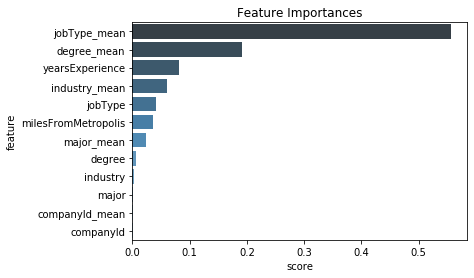

In [221]:
best_model_loaded = model_class.load_model(test_features)

### EDA

In [222]:
# delete once finished
train_eda = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
target_eda = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [223]:
class Heatmap:
    def __init__(self, title):
        '''merge training and target df'''
        df_eda = self.merge_df()
        df_eda = data.label_encode(df_eda)
        self._create_corr_df(df_eda, title)

    def merge_df(self):
        '''merging training and target dataframes''' 
        return pd.merge(left=target_eda, right=train_eda, on=col_id, how='inner')

    def _create_corr_df(self, df_eda, title):
        '''creates correlation matrix from train_eda'''
        corr = df_eda[df_eda.columns].corr()
        corr = df_eda.corr()        
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        plt.figure(figsize=(12,10))
        return sns.heatmap(corr, xticklabels=corr.columns.values, 
                           yticklabels=corr.columns.values, cmap='Blues', annot=True)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

In [224]:
class Boxplot:
    def __init__(self):
        '''create train and target dataframes'''
        self.df_eda = hm.merge_df()
        self.target = target_eda[col_target].name
        
    def create_boxplot(self, val, title):
        '''create boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(val)
        sns.boxplot(val, self.target, data=self.df_eda, width=.3, color='#eeefff', order=col_avgs)
        
    def create_dual_boxplot(self, col1, val1, col2, val2, title):
        '''create dual axis boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(col2)
        df_temp = self._create_dataframe(self.df_eda, col1, val1, val2)
        sns.boxplot(x=col2, y=self.target, hue=col1, data=df_temp, palette='Set3', order=col_avgs)
    
    def _create_dataframe(self, df, col1, val1, val2):
        '''create dataframe for dual boxplot'''
        return df[(df[col1]==val1) | (df[col1]==val2)].sort_values(self.target, ascending=True)
    
    def _calc_averages(self, val):
        '''calculate mean values'''
        target = self.target
        df_temp = self.df_eda[[val, target]].groupby(val).mean()
        df_temp = df_temp.sort_values(target, ascending=True).reset_index()
        return df_temp[val].values
    
    def _create_subplot(self):
        '''create subplot'''
        plt.subplots(figsize=(12,6.5))
        
    def _set_title(self, title):
        '''create title'''
        plt.title(title)

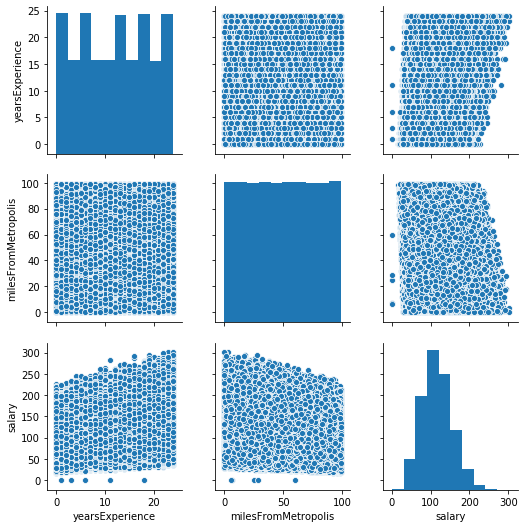

In [225]:
sns.pairplot(data.train_eda)

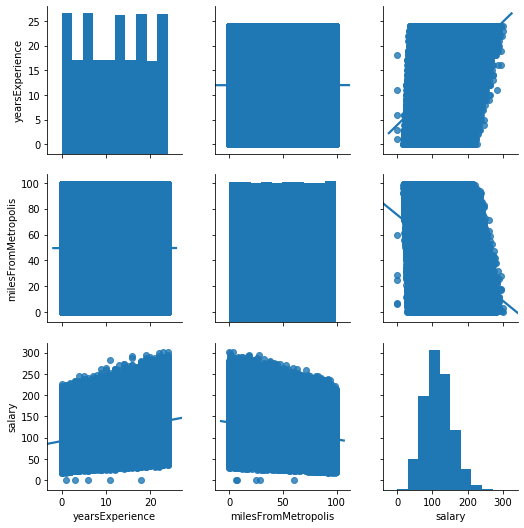

In [226]:
sns.pairplot(data.train_eda, kind='reg')

### Instantiate Heatmap and Boxplot objects

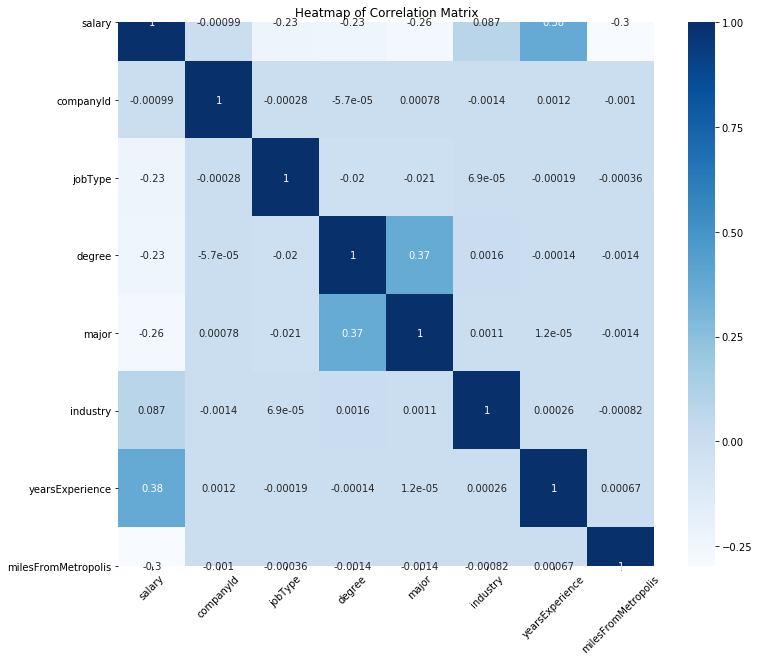

In [227]:
hm = Heatmap('Heatmap of Correlation Matrix');

In [228]:
bp = Boxplot()

In [229]:
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [230]:
train_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [231]:
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [232]:
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [233]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [234]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [235]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [236]:
train_features_sum = train_features_df.duplicated().sum()
train_target_sum = train_target_df.duplicated().sum()
test_features_sum = test_features_df.duplicated().sum()
columns = train_features_df.columns
print('Train features duplicates: {}\nTrain target duplicates: {} \nTest features duplicates: {}\n'.format(train_features_sum, train_target_sum, test_features_sum))
print('Train feature columns:\n', list(columns))

Train features duplicates: 0
Train target duplicates: 0 
Test features duplicates: 0

Train feature columns:
 ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [237]:
col_num = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
col_cat = ['yearsExperience', 'milesFromMetropolis']
col_id = 'jobId'

In [238]:
train_features_df.describe(include = np.number)

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [239]:
train_features_df.describe(include = np.object)

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684947825,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [240]:
train_df = pd.merge(train_features_df, train_target_df, on=col_id)
train_target = train_target_df

In [241]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [242]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [243]:
class TargetVisualization:
    def __init__(self):
        '''create train and target dataframe'''
        self.df_eda = hm.merge_df()
        self.target = target_eda[col_target]
        self._create_plots()
        self._calculate_iqr()
        
    def _create_plots(self):
        '''create boxplot and distplot'''
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.boxplot(self.df_eda[col_target])
        plt.subplot(1,2,2)
        sns.distplot(self.df_eda[col_target], bins=20)
        plt.show()
        
    def _calculate_iqr(self):
        '''calculate iqr'''
        stat = self.df_eda[col_target].describe()
        iqr = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * iqr
        lower = stat['25%'] - 1.5 * iqr
        print('Upper and lower bounds for potential outliers are {} and {}.'.format(upper,lower))

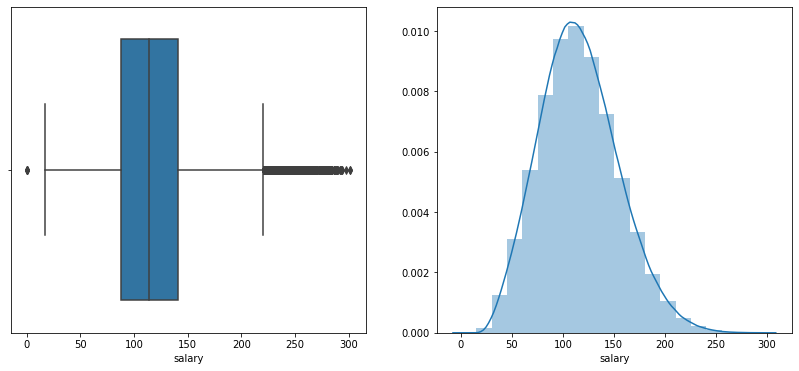

Upper and lower bounds for potential outliers are 220.5 and 8.5.


In [244]:
tv = TargetVisualization()

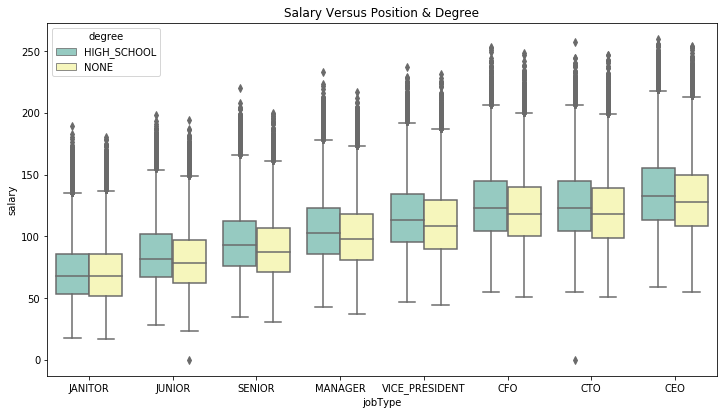

In [245]:
bp.create_dual_boxplot(col1='degree', val1='HIGH_SCHOOL', 
                       col2='jobType', val2='NONE',
                       title='Salary Versus Position & Degree')

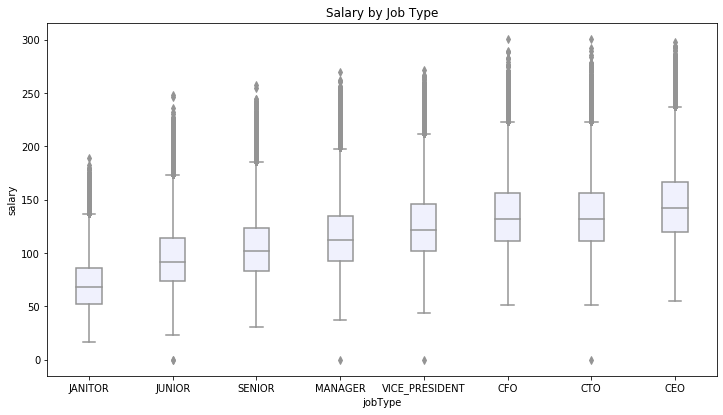

In [246]:
bp.create_boxplot(val='jobType', title='Salary by Job Type')

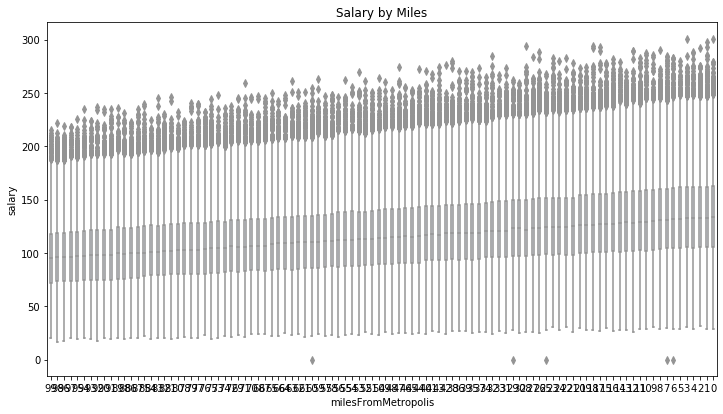

In [247]:
bp.create_boxplot(val='milesFromMetropolis', title='Salary by Miles')

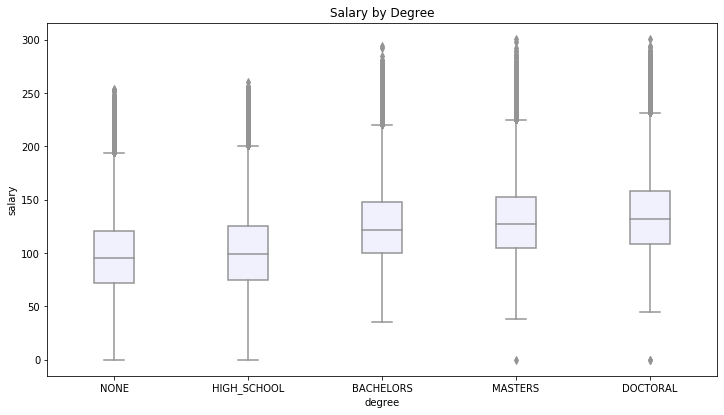

In [248]:
bp.create_boxplot(val='degree', title='Salary by Degree')

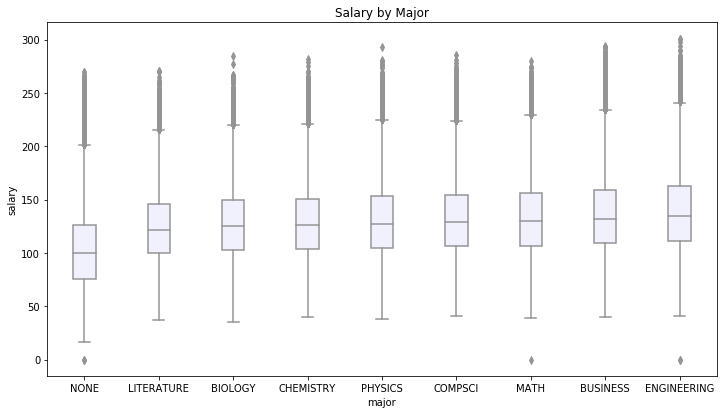

In [249]:
bp.create_boxplot(val='major', title='Salary by Major')

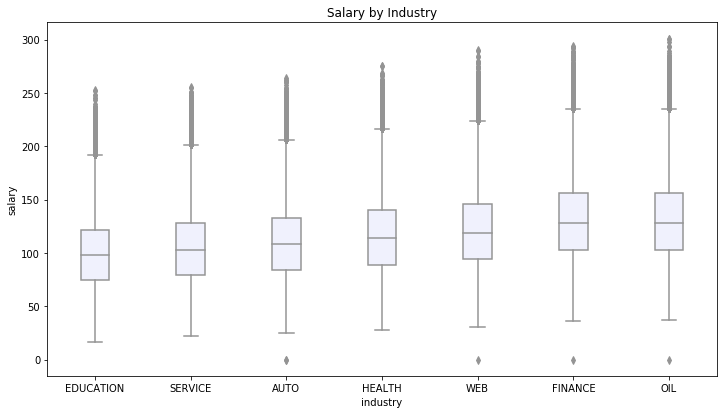

In [250]:
bp.create_boxplot(val='industry', title='Salary by Industry')